[Deep Learning Summer School 2019](http://2019.dl-lab.eu) in Gdansk, Poland  
Ordinal Regression Tutorial by [Sebastian Raschka](https://sebastianraschka.com)  
GitHub Repository: https://github.com/rasbt/DL-Gdansk2019-tutorial  

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.8
IPython 7.2.0

torch 1.1.0


## Imports

In [2]:
import time
import os
import pandas as pd
import numpy as np
import torch

from PIL import Image
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## General Settings

In [3]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.00005
NUM_EPOCHS = 30
BATCH_SIZE = 64

DEVICE = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

## Dataset

In [4]:
TRAIN_CSV_PATH = 'training_set.csv'
TEST_CSV_PATH = 'test_set.csv'
IMAGE_PATH = 'UTKFace'

In [5]:
from dataloader import UTKDatasetAge

In [6]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
NUM_CLASSES = np.unique(df_train['age'].values).shape[0]


train_indices = torch.arange(0, df_train.shape[0]-1000).numpy()
valid_indices = torch.arange(df_train.shape[0]-1000, df_train.shape[0]).numpy()
del df_train



train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)



train_transform = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.RandomCrop((120, 120)),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.CenterCrop((120, 120)),
                                     transforms.ToTensor()])


train_dataset = UTKDatasetAge(csv_path=TRAIN_CSV_PATH,
                              img_dir=IMAGE_PATH,
                              transform=train_transform)

valid_dataset = UTKDatasetAge(csv_path=TRAIN_CSV_PATH,
                              img_dir=IMAGE_PATH,
                              transform=test_transform)

test_dataset = UTKDatasetAge(csv_path=TEST_CSV_PATH,
                             img_dir=IMAGE_PATH,
                             transform=test_transform)




train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=8,
                          sampler=train_sampler)

valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=8,
                          sampler=valid_sampler)


test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)


# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 3, 120, 120])
Image label dimensions: torch.Size([64])


## Model Setup

In [7]:
##########################
# MODEL
##########################

from vgg16 import VGG16Base


class VGG16CrossEntropy(VGG16Base):
    def __init__(self, num_classes):
        super(VGG16CrossEntropy, self).__init__(num_classes)
        
        self.classifier = nn.Sequential(
            nn.Linear(512*3*3, 4096),
            nn.ReLU(),   
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, self.num_classes)
        )

    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        logits = self.classifier(x.view(x.size(0), -1))
        probas = F.softmax(logits, dim=1)

        return logits, probas

### Initialize the Model

In [8]:
###########################################
# Initialize Cost, Model, and Optimizer
###########################################

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
model = VGG16CrossEntropy(NUM_CLASSES)

model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Model Training

In [9]:
def compute_mae_mse_acc(model, data_loader, device):
    mae, mse, acc, num_examples = 0., 0., 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        acc += torch.sum(predicted_labels == targets)
        mae += torch.sum(torch.abs(predicted_labels - targets))
        mse += torch.sum((predicted_labels - targets)**2)
    acc = acc.float() / num_examples   
    mae = mae.float() / num_examples
    mse = mse.float() / num_examples
    return mae, mse, acc


In [10]:
start_time = time.time()

# use random seed for reproducibility (here batch shuffling)
torch.manual_seed(RANDOM_SEED)

cost_list = []
train_mae_list, valid_mae_list = [], []
train_mse_list, valid_mse_list = [], []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)

        optimizer.zero_grad()        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 25:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

            
    # no need to build the computation graph for backprop when computing accuracy
    with torch.set_grad_enabled(False):
        
        train_mae, train_mse, train_acc = compute_mae_mse_acc(
                model, train_loader, device=DEVICE)
        valid_mae, valid_mse, valid_acc = compute_mae_mse_acc(
                model, valid_loader, device=DEVICE)
 
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train MAE: {train_mae:.2f} | Validation MAE: {valid_mae:.2f}')
        
        train_mae_list.append(train_mae)
        valid_mae_list.append(valid_mae)
        train_mse_list.append(train_mse)
        valid_mse_list.append(valid_mse)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/030 | Batch 000/191 | Cost: 3.6891
Epoch: 001/030 | Batch 025/191 | Cost: 3.4181
Epoch: 001/030 | Batch 050/191 | Cost: 3.3667
Epoch: 001/030 | Batch 075/191 | Cost: 3.5126
Epoch: 001/030 | Batch 100/191 | Cost: 3.3245
Epoch: 001/030 | Batch 125/191 | Cost: 3.5294
Epoch: 001/030 | Batch 150/191 | Cost: 3.5104
Epoch: 001/030 | Batch 175/191 | Cost: 3.4936
Epoch: 001/030
Train MAE: 9.79 | Validation MAE: 9.50
Time elapsed: 1.24 min
Epoch: 002/030 | Batch 000/191 | Cost: 3.5468
Epoch: 002/030 | Batch 025/191 | Cost: 3.2959
Epoch: 002/030 | Batch 050/191 | Cost: 3.3392
Epoch: 002/030 | Batch 075/191 | Cost: 3.3626
Epoch: 002/030 | Batch 100/191 | Cost: 3.3804
Epoch: 002/030 | Batch 125/191 | Cost: 3.4147
Epoch: 002/030 | Batch 150/191 | Cost: 3.3715
Epoch: 002/030 | Batch 175/191 | Cost: 3.4438
Epoch: 002/030
Train MAE: 9.79 | Validation MAE: 9.50
Time elapsed: 2.48 min
Epoch: 003/030 | Batch 000/191 | Cost: 3.2921
Epoch: 003/030 | Batch 025/191 | Cost: 3.5310
Epoch: 003/030 | B

## Evaluation

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

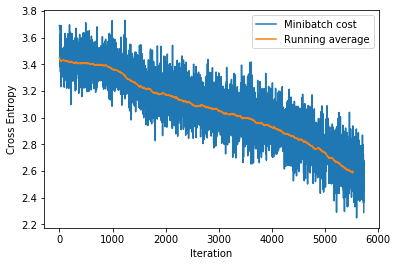

In [12]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

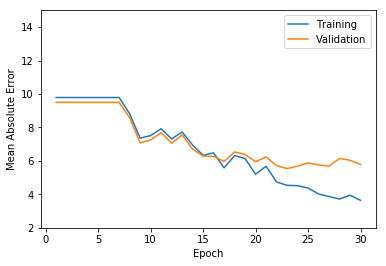

In [17]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_mae_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_mae_list, label='Validation')
plt.ylim(2, 15)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

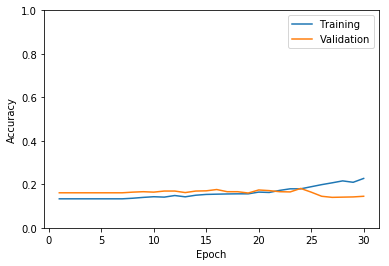

In [18]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
with torch.set_grad_enabled(False):
    test_mae, test_mse, test_acc = compute_mae_mse_acc(model=model,
                                                       data_loader=test_loader,
                                                       device=DEVICE)
    
print(f'Test MAE: {test_mae:.2f}')
print(f'Test MSE: {test_mse:.2f}')
print(f'Test ACC: {test_acc*100:.2f}%')

Test MAE: 6.24
Test MSE: 80.05
Test ACC: 13.26%
